In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn import datasets
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

import pandas as pd

import warnings

from SocialMediaIE.data.tokenization import tokenize

In [2]:
sns.set_context("talk")
sns.set_style("ticks")
np.random.seed(1337)
warnings.simplefilter("ignore")

In [3]:
df_lexicon = pd.read_csv("../data/sentiments.csv")
df_lexicon = df_lexicon[df_lexicon.score.isnull()].drop("score", axis=1).assign(
    lexicon_label=lambda x: x.sentiment.str.cat(x.lexicon, sep="_")
)
df_lexicon.head()

,word,sentiment,lexicon,lexicon_label
0,abacus,trust,nrc,trust_nrc
1,abandon,fear,nrc,fear_nrc
2,abandon,negative,nrc,negative_nrc
3,abandon,sadness,nrc,sadness_nrc
4,abandoned,anger,nrc,anger_nrc


In [4]:
df_lexicon.groupby("word").lexicon_label.apply(list).head()

word
2-faced                                      [negative_bing]
2-faces                                      [negative_bing]
a+                                           [positive_bing]
abacus                                           [trust_nrc]
abandon    [fear_nrc, negative_nrc, sadness_nrc, negative...
Name: lexicon_label, dtype: object

In [5]:
SENTIMENT_LEXICON=df_lexicon.groupby("word").lexicon_label.apply(list).to_dict()
SENTIMENT_LEXICON["abandon"]

['fear_nrc', 'negative_nrc', 'sadness_nrc', 'negative_mcdonald']

In [11]:
list(filter(lambda x: x, [1, "", 2]))

[1, 2]

In [6]:
def process_token(token):
    token = token.lower()
    if token.startswith("@"):
        return "@USER"
    if token.startswith("#"):
        return "#HASHTAG"
    if token.startswith(("http://", "https://", "www.")):
        return "http://URL.COM"
    return token

def preprocess_text(text):
    tokens = [process_token(token) for token in tokenize(text)]
    lexicon_items = sum([SENTIMENT_LEXICON.get(k, []) for k in tokens], [])
    return tokens+lexicon_items

In [7]:
DATA_KEY="SemEval"
df_train = pd.read_json(f"../data/processed/SENTIMENT/{DATA_KEY}/train.json", orient="records", lines=True)
df_dev = pd.read_json(f"../data/processed/SENTIMENT/{DATA_KEY}/dev.json", orient="records", lines=True)
df_test = pd.read_json(f"../data/processed/SENTIMENT/{DATA_KEY}/test.json", orient="records", lines=True)
df_train.head()

,label,text,tweet_id
0,neutral,Today's news: Democrats offer Republicans ever...,90832477970636801
1,neutral,@stanscates I would use that in ads from now u...,90835879622488064
2,neutral,"Microsoft issues critical patch for Windows 7,...",90854967476363265
3,neutral,will testdrive the new Nokia N9 phone with our...,90905261992194048
4,negative,no way to underestimate the madness and cynici...,90965889557594112


In [8]:
df_train.text.head().apply(preprocess_text)

0    [today's, news, :, democrats, offer, republica...
1    [@USER, i, would, use, that, in, ads, from, no...
2    [microsoft, issues, critical, patch, for, wind...
3    [will, testdrive, the, new, nokia, n, 9, phone...
4    [no, way, to, underestimate, the, madness, and...
Name: text, dtype: object

In [9]:
steps = [('TfidfVectorizer', TfidfVectorizer(tokenizer=preprocess_text)), ('model', LogisticRegression())]
model = Pipeline(steps)

In [10]:
model.fit(df_train.text, df_train.label)

Pipeline(memory=None,
     steps=[('TfidfVectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [11]:
model.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [12]:
stats.entropy(model.predict_proba(df_dev.head(10).text).T)

array([0.76540138, 0.85810154, 0.45975235, 1.08641873, 0.8809548 ,
       0.59857655, 0.6321533 , 0.77115378, 0.84610299, 0.91418489])

In [13]:
def classification_metrics(df, model):
    true_labels = df.label
    predicted_labels = model.predict(df.text)
    report = pd.DataFrame(classification_report(true_labels, predicted_labels, output_dict=True)).T
    cm = confusion_matrix(true_labels, predicted_labels)
    cm = pd.DataFrame(cm, columns=model.classes_, index=model.classes_)
    return cm, report

classification_metrics(df_dev, model)

(          negative  neutral  positive
 negative       242      429       165
 neutral        151     1231       397
 positive        83      764      1121,
               f1-score  precision    recall  support
 negative      0.368902   0.508403  0.289474    836.0
 neutral       0.585772   0.507838  0.691962   1779.0
 positive      0.614078   0.666072  0.569614   1968.0
 micro avg     0.566005   0.566005  0.566005   4583.0
 macro avg     0.522918   0.560771  0.517016   4583.0
 weighted avg  0.558367   0.575889  0.566005   4583.0)

In [14]:
def get_predictions(df, model, scoring=stats.entropy):
    predictions = model.predict_proba(df.text)
    selection_scores = scoring(predictions.T)
    predictions = pd.DataFrame(predictions, columns=model.classes_, index=df.index)
    predictions["selection_scores"] = selection_scores
    return pd.concat([df, predictions], axis=1)

In [15]:
df_pred = get_predictions(df_dev, model)
df_pred.sort_values("selection_scores", ascending=False).head(10)

,label,text,tweet_id,negative,neutral,positive,selection_scores
1892,neutral,@mrpete1972 @MyTeamStorm UKIP was on media bla...,633658499952676864,0.326979,0.341115,0.331906,1.098458
879,neutral,My mums going to Liverpool shopping tomorrow a...,264157870948495360,0.346976,0.324369,0.328655,1.098182
896,negative,Oh God can ABC be more obvious? They keep tout...,264169551183376385,0.320023,0.343406,0.336571,1.098177
4232,positive,taylor swift will be 5 hours away from me tom...,641453487667048448,0.347962,0.318243,0.333794,1.097949
3818,negative,"Hey @TonyAbbottMHR, the Pope missed your commu...",641176871145635840,0.324611,0.324648,0.350741,1.097936
2796,positive,Today is the 28th Anniversary of Michael Jacks...,638342682117570560,0.315761,0.334439,0.349801,1.097739
421,negative,Come scoop meRT @_BoatsnHoes: I gotta go shopp...,263146025630437376,0.337547,0.314039,0.348414,1.097680
1853,neutral,There's one difference here. HHH was never Ric...,633462328588148736,0.356337,0.316718,0.326945,1.097353
3469,positive,.@rebs_0 Valentine was the first PTX song that...,640324637075894272,0.336437,0.311028,0.352535,1.097292
311,negative,Napoleon Dynamite may be the most awkward pers...,262288470612013056,0.308747,0.346287,0.344966,1.097233


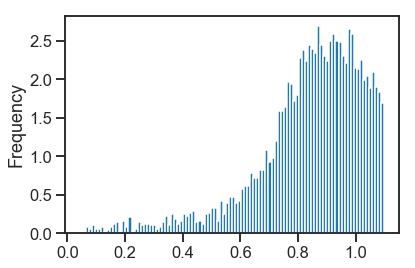

In [16]:
df_pred.selection_scores.plot(kind="hist", bins=100, density=True, weights=np.ones_like(df_pred.selection_scores))

In [17]:
df_train.shape

(12245, 3)

In [18]:
df_train["selected"] = False
SEED_SIZE=1000
selected_indexes = np.random.choice(df_train.index, size=SEED_SIZE, replace=False)
df_train.loc[selected_indexes, "selected"] = True
selected_indexes.shape

(1000,)

In [19]:
df_train[df_train.selected].head()

,label,text,tweet_id,selected
1,neutral,@stanscates I would use that in ads from now u...,90835879622488064,True
13,neutral,Democrats defeat Republicans 8-2 in Congressio...,91687000574394370,True
22,negative,@charliemax Democrats will quickly implode and...,96679152068988928,True
31,negative,I'm stuck in London again... :( I don't wanna ...,100001199650123776,True
45,neutral,Trying to go out tonight!!! Where is there to ...,100002743019769856,True


In [20]:
np.hstack([selected_indexes, selected_indexes])

array([4524, 5964, 2810, ..., 1108, 7135, 6571], dtype=int64)

In [21]:
base_metrics = {}
base_metrics["train"] = classification_metrics(df_train, model)
base_metrics["dev"] = classification_metrics(df_dev, model)
base_metrics["test"] = classification_metrics(df_test, model)

In [22]:
SEED_SIZE=1000
selected_indexes = np.random.choice(df_train.index, size=SEED_SIZE, replace=False)

In [23]:
def plot_metrics(metrics, key="f1-score", base_metric=None):
    df_metrics = pd.concat([
        iter_metrics[1][key].to_frame().T.melt(var_name="metric").assign(iteration=i)
        for i, iter_metrics in enumerate(metrics)
    ], axis=0)
    g = sns.FacetGrid(df_metrics, col="metric", sharey=True, ylim=(0, 1))
    g.map(plt.plot, "iteration", "value", marker=".")
    if base_metric is not None:
        for ax, c in zip(g.axes.flatten(), g.col_names):
            ax.axhline(y=base_metric[1].loc[c, key], color="k", linestyle="--")
    return df_metrics

## Experiments using max entropy selection

In [24]:
df_train["selected"] = False
df_train.loc[selected_indexes, "selected"] = True

train_metrics = []
dev_metrics = []
test_metrics = []
training_indexes = selected_indexes
ANNOTATIONS_PER_STEP=100
MAX_ITERATIONS=10

steps = [
    ('TfidfVectorizer', TfidfVectorizer(tokenizer=preprocess_text, stop_words="english")), 
    ('model', LogisticRegression())
]
model = Pipeline(steps)

for i in range(MAX_ITERATIONS):
    print(f"Starting iteration {i}")
    # Identifiy selected data
    df_selected = df_train[df_train.selected]
    df_unselected = df_train[~df_train.selected]
    # Fit model
    model.fit(df_selected.text, df_selected.label)
    # Get model metrics
    train_metrics.append(classification_metrics(df_unselected, model))
    dev_metrics.append(classification_metrics(df_dev, model))
    test_metrics.append(classification_metrics(df_test, model))
    #print(f"Dev metrics: {dev_metrics[-1][1]}")
    #print(f"Test metrics: {test_metrics[-1][1]}")
    # Get model predictions on unselected data
    df_pred = get_predictions(df_unselected, model)
    #df_pred.selection_scores.plot(kind="hist", bins=100, density=True)
    #plt.show()
    # Identify top instances to label
    new_indexes = df_pred.sort_values("selection_scores", ascending=False).head(ANNOTATIONS_PER_STEP).index
    print(f"Selected data distribution: {df_pred.loc[new_indexes].label.value_counts().to_dict()}")
    # Add these instances to the training data
    training_indexes = np.hstack([training_indexes, new_indexes])
    df_train.loc[new_indexes, "selected"] = True
    print(f"Total training size: {df_train[df_train.selected].shape[0]}")

# Fit on the last data
df_selected = df_train[df_train.selected]
df_unselected = df_train[~df_train.selected]
model.fit(df_selected.text, df_selected.label)
train_metrics.append(classification_metrics(df_unselected, model))
dev_metrics.append(classification_metrics(df_dev, model))
test_metrics.append(classification_metrics(df_test, model))

Starting iteration 0
Selected data distribution: {'negative': 49, 'neutral': 28, 'positive': 23}
Total training size: 1100
Starting iteration 1
Selected data distribution: {'neutral': 36, 'negative': 35, 'positive': 29}
Total training size: 1200
Starting iteration 2
Selected data distribution: {'negative': 38, 'neutral': 33, 'positive': 29}
Total training size: 1300
Starting iteration 3
Selected data distribution: {'neutral': 42, 'negative': 30, 'positive': 28}
Total training size: 1400
Starting iteration 4
Selected data distribution: {'neutral': 43, 'negative': 32, 'positive': 25}
Total training size: 1500
Starting iteration 5
Selected data distribution: {'neutral': 42, 'negative': 35, 'positive': 23}
Total training size: 1600
Starting iteration 6
Selected data distribution: {'neutral': 44, 'positive': 37, 'negative': 19}
Total training size: 1700
Starting iteration 7
Selected data distribution: {'neutral': 38, 'negative': 33, 'positive': 29}
Total training size: 1800
Starting iterati

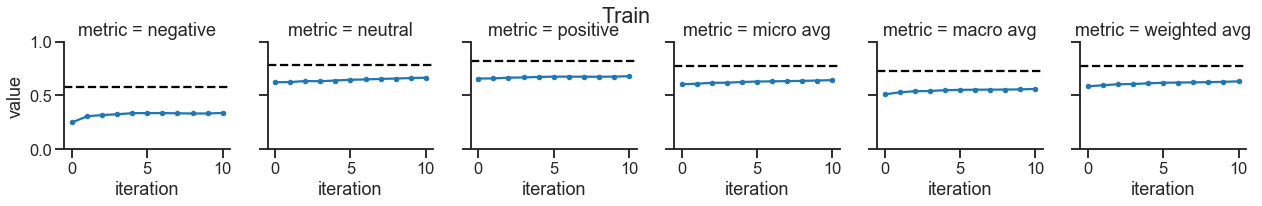

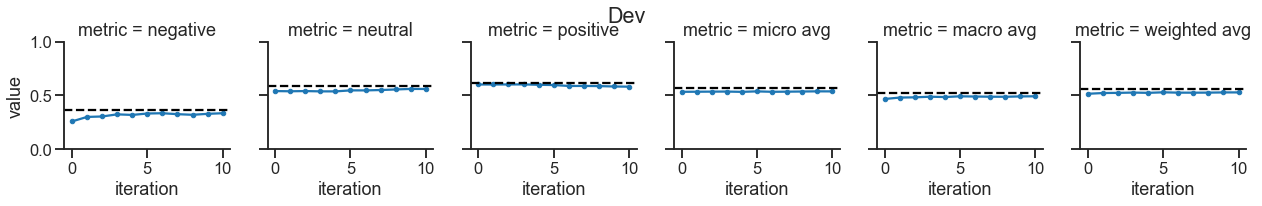

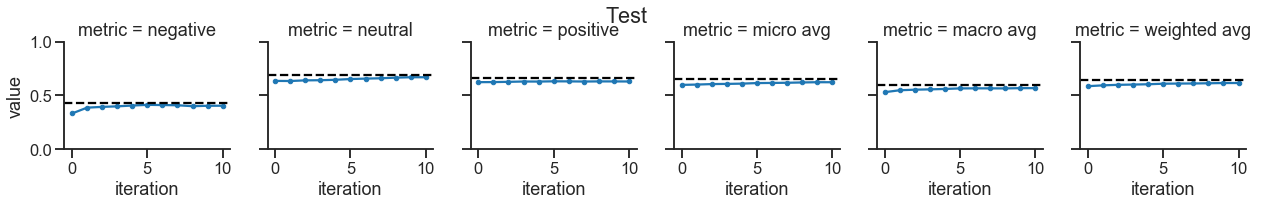

In [25]:
plot_metrics(train_metrics, base_metric=base_metrics["train"]);
plt.suptitle("Train");
plot_metrics(dev_metrics, base_metric=base_metrics["dev"]);
plt.suptitle("Dev");
plot_metrics(test_metrics, base_metric=base_metrics["test"]);
plt.suptitle("Test");

value                                                     
metric    macro avg micro avg  negative   neutral  positive weighted avg
iteration                                                               
0          0.530780  0.598494  0.332927  0.635594  0.623820     0.586439
1          0.548654  0.601350  0.386907  0.634539  0.624517     0.594177
2          0.553905  0.605939  0.394222  0.640645  0.626846     0.599059
3          0.556995  0.607670  0.399144  0.641884  0.629957     0.601538
4          0.560659  0.610180  0.406665  0.645901  0.629410     0.604377
5          0.565865  0.615331  0.413024  0.652834  0.631738     0.609513
6          0.566391  0.616716  0.411146  0.656954  0.631072     0.610967
7          0.566287  0.618231  0.409205  0.659893  0.629762     0.611604
8          0.565753  0.621088  0.400657  0.665691  0.630911     0.613552
9          0.568243  0.623426  0.404498  0.669508  0.630724     0.615884
10         0.568211  0.623166  0.404995  0.669542  0.630097     0.615741

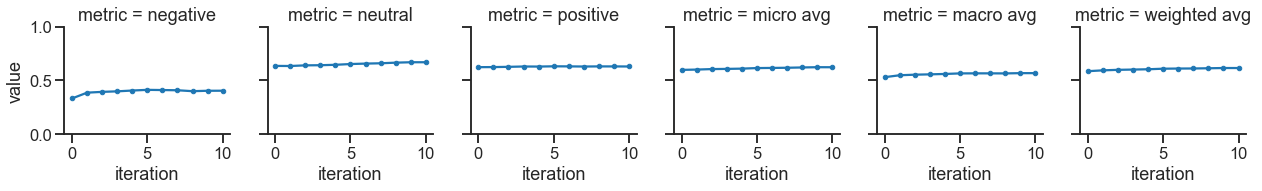

In [26]:
plot_metrics(test_metrics).pivot(index="iteration", columns="metric")

In [27]:
base_metrics["train"]

(          negative  neutral  positive
 negative       789      666       281
 neutral        131     4379       713
 positive        62      883      4341,
               f1-score  precision    recall  support
 negative      0.580574   0.803462  0.454493   1736.0
 neutral       0.785400   0.738698  0.838407   5223.0
 positive      0.817437   0.813683  0.821226   5286.0
 micro avg     0.776562   0.776562  0.776562  12245.0
 macro avg     0.727804   0.785281  0.704709  12245.0
 weighted avg  0.770192   0.780250  0.776562  12245.0)

## Experiments using min margin difference

In [28]:
def min_margin_scoring(predictions):
    """Difference between the top prediction score and next prediction score
    
    predictions: it is n_labels x n_instances
    
    returns:
        n_instances np.array
    """
    prediction_values = np.sort(predictions, axis=0)[-2:, :]
    margin = prediction_values[-1] - prediction_values[-2]
    return margin

In [29]:
np.sort(model.predict_proba(df_dev.head(10).text).T, axis=0)[-2:, :][-2]

array([0.34879655, 0.30072185, 0.2093319 , 0.34552407, 0.42091988,
       0.20089244, 0.25978973, 0.27245263, 0.34894669, 0.28634118])

In [30]:
min_margin_scoring(model.predict_proba(df_dev.head(10).text).T)

array([0.19507107, 0.13877572, 0.49609675, 0.05791894, 0.00630884,
       0.47267852, 0.31676016, 0.35883191, 0.15301023, 0.29194455])

In [31]:
df_pred = get_predictions(df_dev, model, scoring=min_margin_scoring)
df_pred.sort_values("selection_scores", ascending=True).head(10)

,label,text,tweet_id,negative,neutral,positive,selection_scores
2350,positive,tomorrow a shooting day ! gonna spend whole da...,636061301609922560,0.216506,0.391748,0.391746,0.000003
3061,negative,The LAST thing we need is more corn and more M...,639274258598748160,0.130084,0.434916,0.434999,0.000083
3052,negative,Nice One Hillary...don't want to mention Tar S...,639240697934057473,0.327535,0.336145,0.336320,0.000175
421,negative,Come scoop meRT @_BoatsnHoes: I gotta go shopp...,263146025630437376,0.311527,0.344411,0.344061,0.000350
2478,negative,@steve196508 Evrn worse for people born around...,636774312062619649,0.403393,0.403759,0.192848,0.000366
4567,positive,"Fashion is Serena's 2nd love, she has a collec...",641666231993548800,0.113075,0.443223,0.443702,0.000479
1417,neutral,@wildandkyung btw from one gay babe to another...,626461225405313024,0.183517,0.407987,0.408496,0.000509
4504,negative,@BitterOldJoe it gave the impression the whole...,641631867461050368,0.107007,0.446779,0.446213,0.000566
2092,positive,SD News - SD Opera figure makes Tom Cruise loo...,634780207472353281,0.073707,0.463464,0.462829,0.000635
3197,negative,If Scotland woke up tomorrow and decided we we...,639737580859326464,0.237801,0.380714,0.381485,0.000770


In [32]:
df_train["selected"] = False
df_train.loc[selected_indexes, "selected"] = True

train_metrics = []
dev_metrics = []
test_metrics = []
training_indexes = selected_indexes
ANNOTATIONS_PER_STEP=100
MAX_ITERATIONS=10

steps = [
    ('TfidfVectorizer', TfidfVectorizer(tokenizer=preprocess_text, stop_words="english")), 
    ('model', LogisticRegression())
]
model = Pipeline(steps)

for i in range(MAX_ITERATIONS):
    print(f"Starting iteration {i}")
    # Identifiy selected data
    print(f"df_train: {df_train.shape}")
    df_selected = df_train[df_train.selected]
    print(f"df_selected: {df_selected.shape}")
    df_unselected = df_train[~df_train.selected]
    print(f"df_unselected: {df_unselected.shape}")
    # Fit model
    model.fit(df_selected.text, df_selected.label)
    # Get model metrics
    train_metrics.append(classification_metrics(df_unselected, model))
    dev_metrics.append(classification_metrics(df_dev, model))
    test_metrics.append(classification_metrics(df_test, model))
    #print(f"Dev metrics: {dev_metrics[-1][1]}")
    #print(f"Test metrics: {test_metrics[-1][1]}")
    # Get model predictions on unselected data
    df_pred = get_predictions(df_unselected, model, scoring=min_margin_scoring)
    #df_pred.selection_scores.plot(kind="hist", bins=100, density=True)
    #plt.show()
    # Identify top instances to label
    new_indexes = df_pred.sort_values("selection_scores", ascending=True).head(ANNOTATIONS_PER_STEP).index
    print(f"New indexes: {len(new_indexes)}")
    print(f"Selected data distribution: {df_pred.loc[new_indexes].label.value_counts().to_dict()}")
    # Add these instances to the training data
    training_indexes = np.hstack([training_indexes, new_indexes])
    df_train.loc[new_indexes, "selected"] = True
    print(f"Total training size: {df_train[df_train.selected].shape[0]}")

# Fit on the last data
df_selected = df_train[df_train.selected]
df_unselected = df_train[~df_train.selected]
model.fit(df_selected.text, df_selected.label)
train_metrics.append(classification_metrics(df_unselected, model))
dev_metrics.append(classification_metrics(df_dev, model))
test_metrics.append(classification_metrics(df_test, model))

Starting iteration 0
df_train: (12245, 4)
df_selected: (1000, 4)
df_unselected: (11245, 4)
New indexes: 100
Selected data distribution: {'neutral': 44, 'positive': 34, 'negative': 22}
Total training size: 1100
Starting iteration 1
df_train: (12245, 4)
df_selected: (1100, 4)
df_unselected: (11145, 4)
New indexes: 100
Selected data distribution: {'neutral': 46, 'positive': 38, 'negative': 16}
Total training size: 1200
Starting iteration 2
df_train: (12245, 4)
df_selected: (1200, 4)
df_unselected: (11045, 4)
New indexes: 100
Selected data distribution: {'positive': 43, 'neutral': 35, 'negative': 22}
Total training size: 1300
Starting iteration 3
df_train: (12245, 4)
df_selected: (1300, 4)
df_unselected: (10945, 4)
New indexes: 100
Selected data distribution: {'neutral': 47, 'positive': 33, 'negative': 20}
Total training size: 1400
Starting iteration 4
df_train: (12245, 4)
df_selected: (1400, 4)
df_unselected: (10845, 4)
New indexes: 100
Selected data distribution: {'neutral': 51, 'positiv

In [33]:
df_pred.shape

(10345, 8)

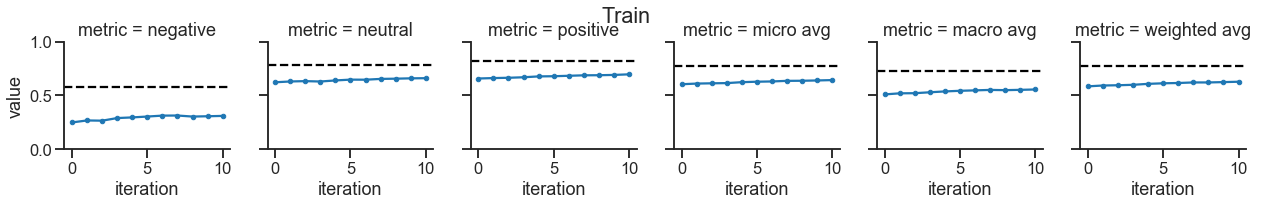

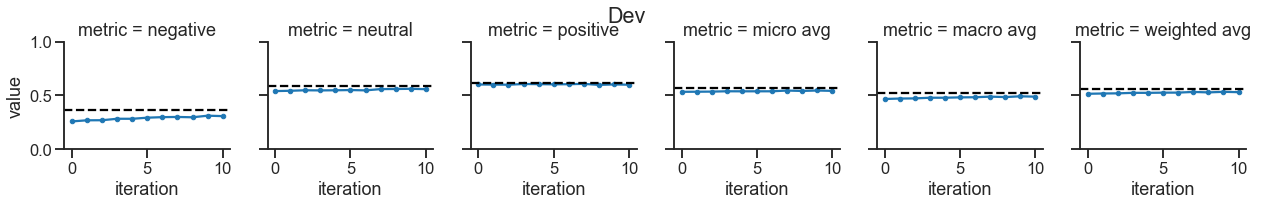

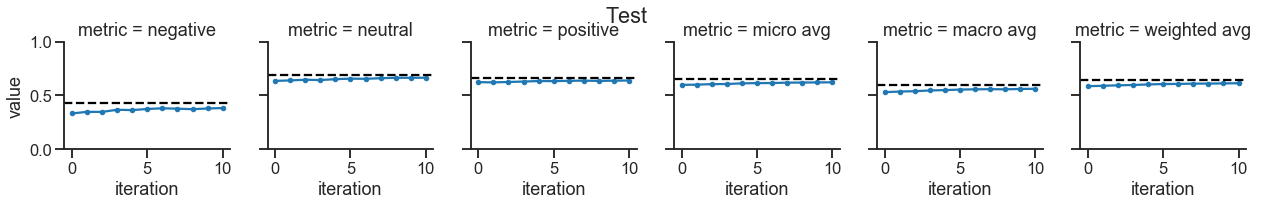

In [34]:
plot_metrics(train_metrics, base_metric=base_metrics["train"]);
plt.suptitle("Train");
plot_metrics(dev_metrics, base_metric=base_metrics["dev"]);
plt.suptitle("Dev");
plot_metrics(test_metrics, base_metric=base_metrics["test"]);
plt.suptitle("Test");

value                                                     
metric    macro avg micro avg  negative   neutral  positive weighted avg
iteration                                                               
0          0.530780  0.598494  0.332927  0.635594  0.623820     0.586439
1          0.536660  0.600788  0.348205  0.639968  0.621806     0.590051
2          0.539809  0.605462  0.347567  0.646297  0.625562     0.594394
3          0.546782  0.606718  0.367261  0.643478  0.629606     0.597456
4          0.550094  0.612518  0.364196  0.651646  0.634440     0.602723
5          0.554922  0.615158  0.374788  0.656528  0.633450     0.606267
6          0.557462  0.615851  0.380952  0.655081  0.636354     0.607563
7          0.558625  0.619227  0.377522  0.660537  0.637817     0.610220
8          0.557401  0.620179  0.372538  0.664287  0.635379     0.610378
9          0.560420  0.621348  0.379161  0.664452  0.637647     0.612280
10         0.562449  0.622343  0.383169  0.664995  0.639182     0.613705

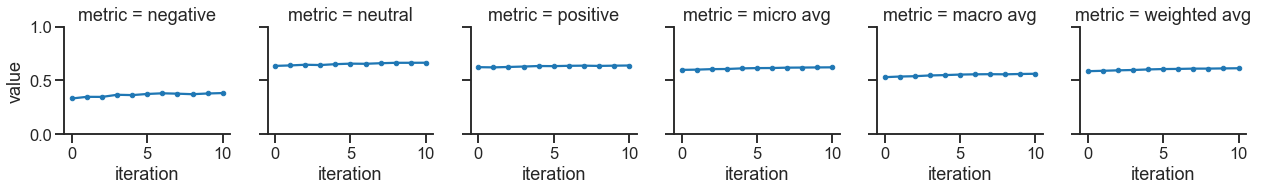

In [35]:
plot_metrics(test_metrics).pivot(index="iteration", columns="metric")

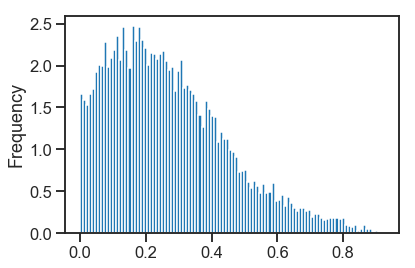

In [36]:
df_pred.selection_scores.plot(kind="hist", bins=100, density=True)